# import

In [2]:
import torchvision
import torch

import os
import numpy as np
from PIL import Image
from torch.utils import data
from torch.utils.data import DataLoader #데이터 불러오기
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
#훈련
from torch import nn
from torch.nn import functional as F
#시각화
import matplotlib.pyplot as plt


In [3]:
print(torch.__version__)

1.8.1+cu102


In [4]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt


def listFiles(rootdir='.', suffix='png'):
    """Performs recursive glob with given suffix and rootdir
        :param rootdir is the root directory
        :param suffix is the suffix to be searched as PNG or JPG
    """
    return [os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames if filename.endswith(suffix)]

cityscapes_valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_map = dict(zip( range(19),cityscapes_valid_classes))

def convertTrainIdToClassId(img):
         temp=np.copy(img)
         for trainID in range(19):
             #print(trainID," " ,class_map[trainID])
             temp[img==trainID]=class_map[trainID]
             
         return temp


def get_cityscapes_labels():
    return np.array([
         #[  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]
        ])



def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, label in enumerate(get_cityscapes_labels()):#get_pascal_labels()
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask


def decode_seg_map_sequence(label_masks, dataset='pascal'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks

def decode_segmap(label_mask, dataset, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    if dataset == 'pascal':
      print()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    
    r[label_mask == 255] = 0
    g[label_mask == 255] = 0
    b[label_mask == 255] =0
    
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
   # rgb = np.zeros((label_mask.shape[1], label_mask.shape[2], 3))
    #replace blue with red as opencv uses bgr
    rgb[:, :, 0] = r /255.0     
    rgb[:, :, 1] = g /255.0
    rgb[:, :, 2] = b /255.0
#    
#    rgb = np.zeros((label_mask.shape[1], label_mask.shape[2], 3))
#    #replace blue with red as opencv uses bgr
#    rgb[:, :, 0] = b #/255.0     
#    rgb[:, :, 1] = g #/255.0
#    rgb[:, :, 2] = r #/255.0
#    
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb
def decode_segmap_cv(label_mask, dataset, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    if dataset == 'pascal':
      print()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    
    r[label_mask == 255] = 0
    g[label_mask == 255] = 0
    b[label_mask == 255] =0
    
#    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
#   # rgb = np.zeros((label_mask.shape[1], label_mask.shape[2], 3))
#    #replace blue with red as opencv uses bgr
#    rgb[:, :, 0] = r /255.0     
#    rgb[:, :, 1] = g /255.0
#    rgb[:, :, 2] = b /255.0
#    
    rgb = np.zeros((label_mask.shape[1], label_mask.shape[2], 3))
    #replace blue with red as opencv uses bgr
    rgb[:, :, 0] = b #/255.0     
    rgb[:, :, 1] = g #/255.0
    rgb[:, :, 2] = r #/255.0
#    
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb
def generate_param_report(logfile, param):
    log_file = open(logfile, 'w')
    for key, val in param.items():
        log_file.write(key + ':' + str(val) + '\n')
    log_file.close()


def lr_poly(base_lr, iter_, max_iter=100, power=0.9):
    return base_lr * ((1 - float(iter_) / max_iter) ** power)


    
from torchvision import transforms 

if __name__ == '__main__':
    print()
    ar=np.array([[0,7,10],[7,3,6]])
    z=convertTrainIdToClassId(ar)
#    img3= transforms.ToPILImage()(torch.from_numpy(ou).type(torch.FloatTensor))#.detach().cpu()
#    img3.save(oupath)
    print(z)


[[ 7 20 23]
 [20 12 19]]


# data loader

## Cityscapes code

In [5]:

#from torch.utils.data import TensorDataset, DataLoader
#from dataloaders.utils import listFiles #모르겠음

class Cityscapes(data.Dataset):

    def __init__(self, root='path', split="train", transform=None,extra=False):
        """
        Cityscapes dataset folder has two folders, 'leftImg8bit' folder for images and 'gtFine_trainvaltest' 
        folder for annotated images with fine annotations 'labels'.
        """
        self.root = os.getenv('HOME')+'/aiffel/siaiffel/liteseg/'
        self.split = split #train, validation, and test sets
        self.transform = transform
        self.files = {}
        self.n_classes = 19
        self.extra=extra

        if not self.extra:
            print("Using fine dataset")
            self.images_path = os.path.join(self.root, 'leftImg8bit_trainvaltest','leftImg8bit', self.split) #실제이미지
            self.labels_path = os.path.join(self.root, 'gtFine_trainvaltest', 'gtFine', self.split) #세그멘테이션 이미지
        else:
            print("Using Coarse dataset")

            self.images_path = os.path.join(self.root, 'leftImg8bit', self.split)
            self.labels_path = os.path.join(self.root, 'gtCoarse', 'gtCoarse', self.split)            
            
        #print(self.images_path)
        self.files[split] = listFiles(rootdir=self.images_path, suffix='.png')#list of the pathes to images

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1] #not to train
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.class_names = ['road', 'sidewalk', 'building', 'wall', 'fence', \
                            'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', \
                            'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', \
                            'motorcycle', 'bicycle']
        
        self.ignore_index = 255
        self.class_map = dict(zip(self.valid_classes, range(self.n_classes)))
        #print(self.class_map)
        
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images.path))

        print("Found %d %s images" % (len(self.files[split]), split))
        
    
    def __len__(self):
        return len(self.files[self.split])
    
    def __getitem__(self, index):
        image_path = self.files[self.split][index].rstrip()
        #print(image_path)
        if not self.extra:
            label_path = os.path.join(self.labels_path,
                                image_path.split(os.sep)[-2],
                                os.path.basename(image_path)[:-15] + 'gtFine_labelIds.png')
        else:
            label_path = os.path.join(self.labels_path,
                                image_path.split(os.sep)[-2],
                                os.path.basename(image_path)[:-15] + 'gtCoarse_labelIds.png')
        _img = Image.open(image_path).convert('RGB')
        _tmp = np.array(Image.open(label_path), dtype=np.uint8)
        _tmp = self.encode_segmap(_tmp)

        _target = Image.fromarray(_tmp)

        sample = {'image': _img, 'label': _target}

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def encode_segmap(self, mask):
        # Put all void classes to ignore_index
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

print("ok")

ok


In [6]:
abcd=Cityscapes()

Using fine dataset
Found 2975 train images


In [27]:
f =abcd.__getitem__(1)

In [28]:
f

{'image': <PIL.Image.Image image mode=RGB size=2048x1024 at 0x7F07E4B77E50>,
 'label': <PIL.Image.Image image mode=L size=2048x1024 at 0x7F07E4C8C510>}

In [33]:
qq =abcd.encode_segmap(f['label'])

TypeError: 'Image' object does not support item assignment

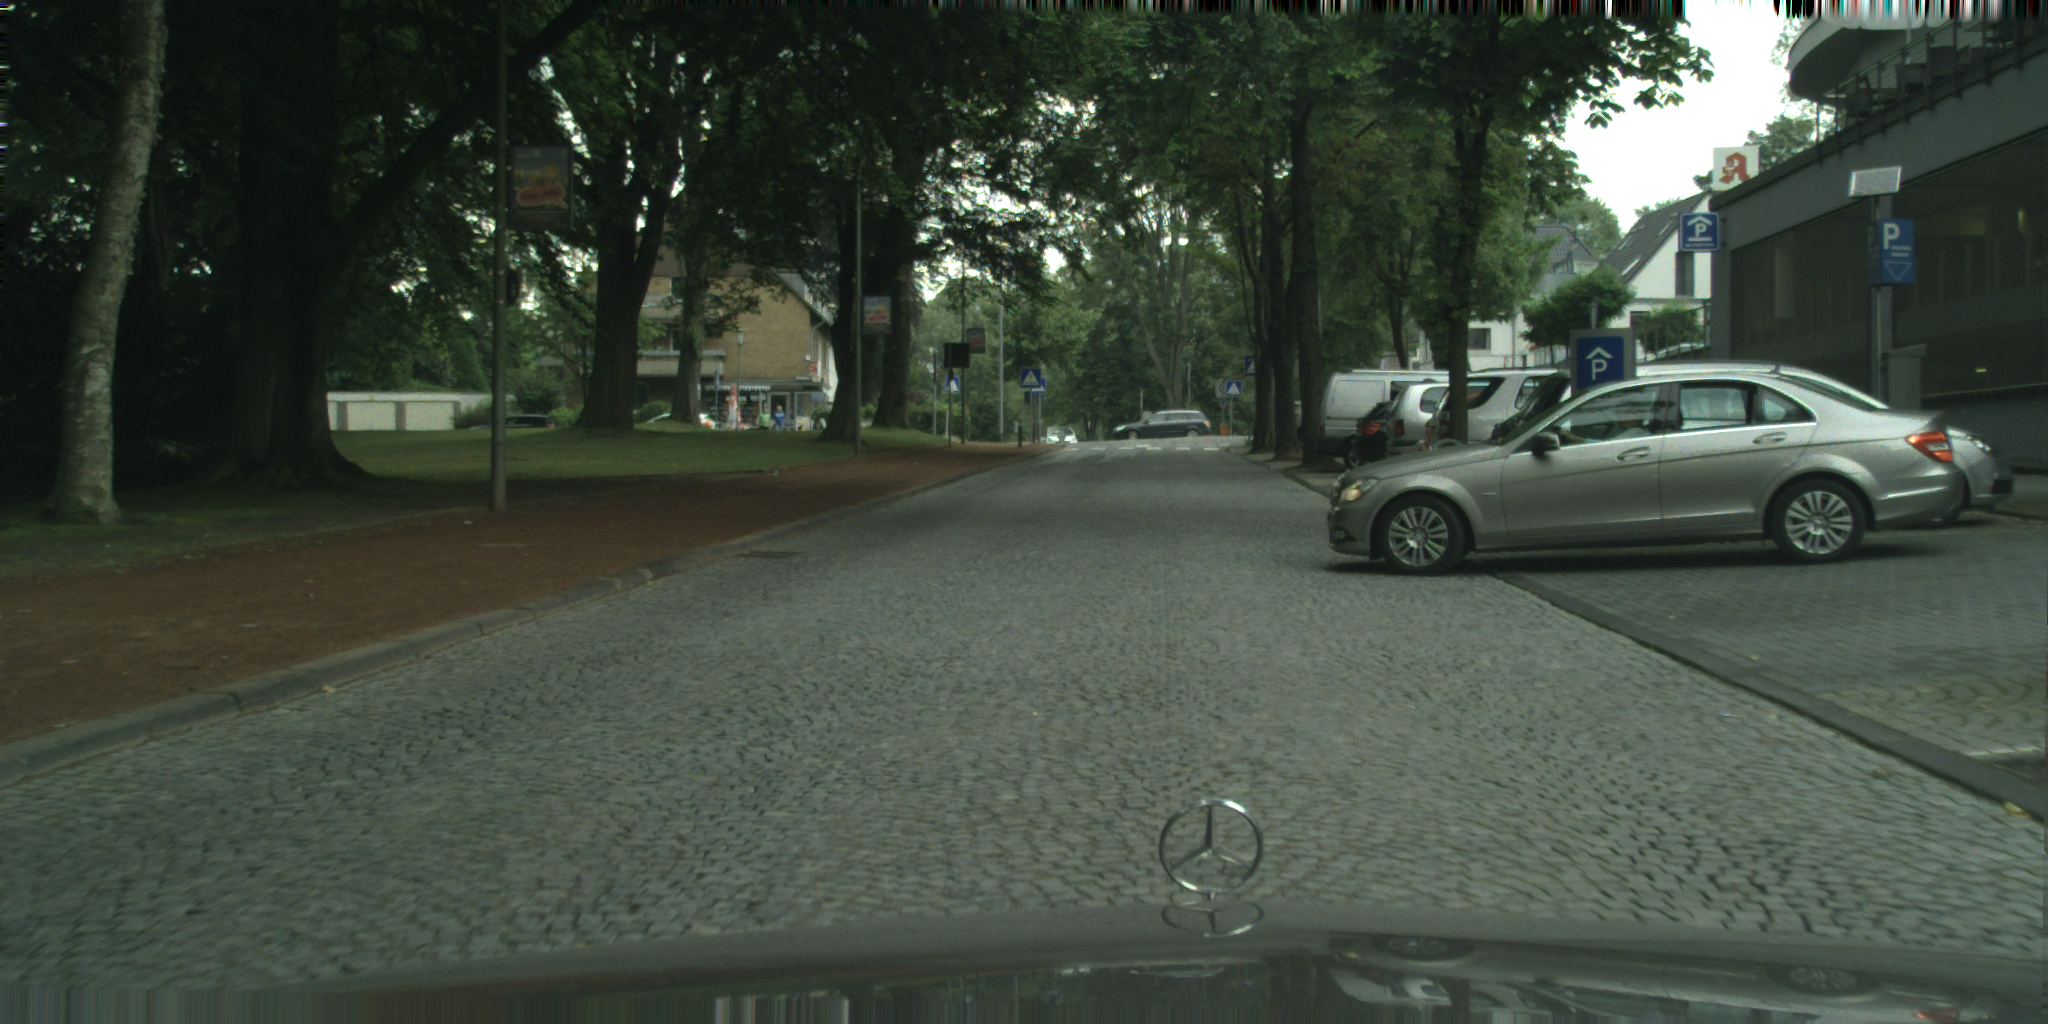

In [29]:
f['image']

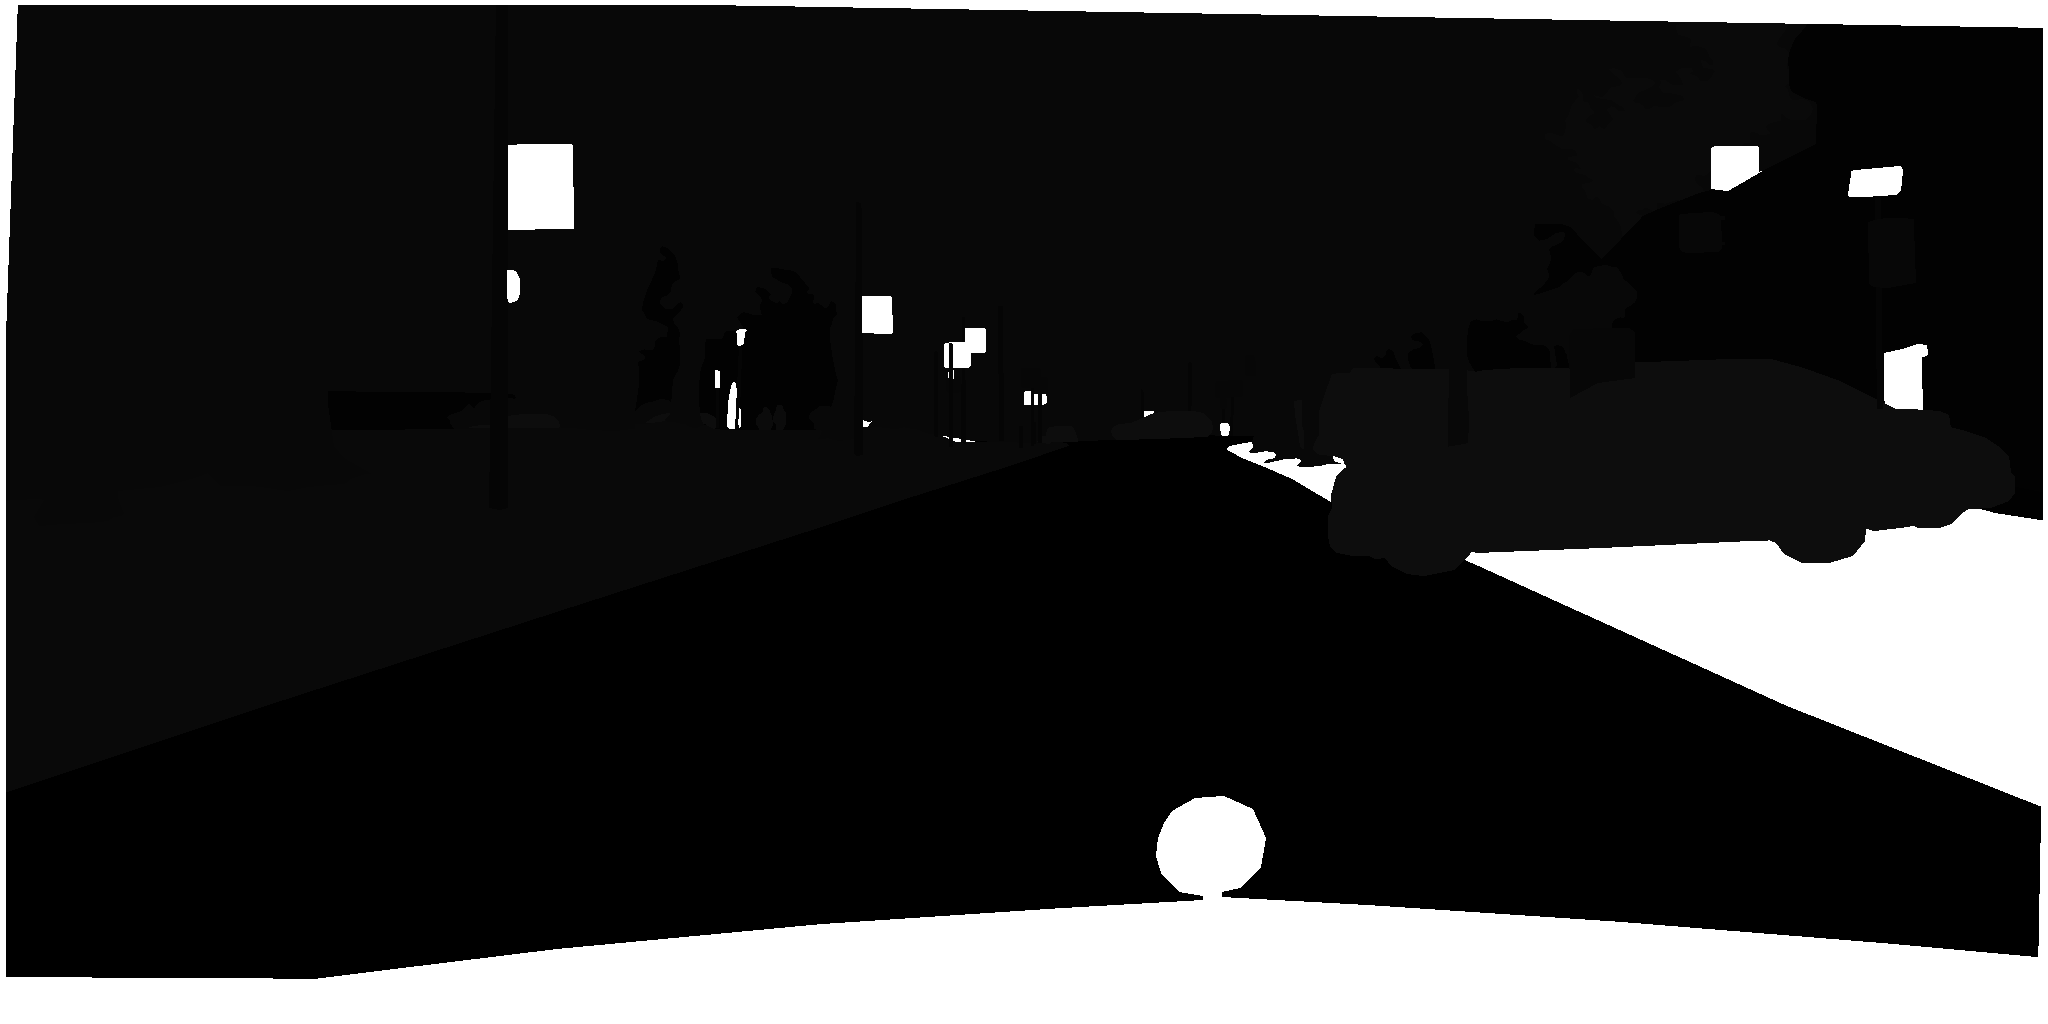

In [30]:
f['label']

# encoder-decoder

In [15]:
import torch.nn as nn
import math

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.): #width_mult:그 숫자만큼 채널에 적용. 채널을 맞추는 변수
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult) #width_mult:그 숫자만큼 채널에 적용. 채널을 맞추는 변수
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        i=0
        for i,l in enumerate( self.features[:4]):
            #print(str(i),x.size())
            x = l(x)
        keep = x
        for z,l in enumerate(self.features[4:]):
            #print(str(z+i+1),x.size())
            x = l(x)
        return x,keep

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
print("ok")

ok


# SeparableConv2d
# ASPP

In [16]:
import torch.nn as nn
import torch
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x
class ASPP(nn.Module):
    
    def __init__(self, inplanes, planes, rate):
        super(ASPP, self).__init__()
        self.rate=rate
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate
            #self.conv1 = nn.Conv2d(planes, planes, kernel_size=3, bias=False,padding=1)
            self.conv1 =SeparableConv2d(planes,planes,3,1,1)
            self.bn1 = nn.BatchNorm2d(planes)
            self.relu1 = nn.ReLU()
   
            #self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
            #                         stride=1, padding=padding, dilation=rate, bias=False)
        self.atrous_convolution = SeparableConv2d(inplanes,planes,kernel_size,1,padding,rate)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        
        
        self._init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)
        #x = self.relu(x)
        if self.rate!=1:
            x=self.conv1(x)
            x=self.bn1(x)
            x=self.relu1(x)
        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [25]:

import torch.nn as nn
import torch.nn.functional as F
import torch
import math

#from models.backbone_networks import MobileNetV2
#from models import aspp # daspp용으로 사용
#from models.separableconv import SeparableConv2d #depwise seperable conv




class RT(nn.Module):
    
    def __init__(self, n_classes=19,PRETRAINED_WEIGHTS=".", pretrained=False):
        
        super(RT, self).__init__()
        print("LiteSeg-MobileNet...")

        self.mobile_features=MobileNetV2() # 백본 모델 
        #self.mobile_features=MobileNetV2.MobileNetV2() # 백본 모델 
        if pretrained:
            state_dict = torch.load(PRETRAINED_WEIGHTS)
            self.mobile_features.load_state_dict(state_dict)
        
        rates = [1, 3, 6, 9] #aspp rate 


        self.aspp1 = ASPP(1280, 96, rate=rates[0]) #1280 (in_channels) 96(out_channels)
        self.aspp2 = ASPP(1280, 96, rate=rates[1])
        self.aspp3 = ASPP(1280, 96, rate=rates[2])
        self.aspp4 = ASPP(1280, 96, rate=rates[3])

        self.relu = nn.ReLU()
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), #fc 연산 대체 
                                             nn.Conv2d(1280, 96, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(96),
                                             nn.ReLU())
        #self.conv1 = nn.Conv2d(480+1280, 96, 1, bias=False)
        self.conv1 =SeparableConv2d(480+1280,96,1) # input채널에 480 더하고 separable conv실행 
        self.bn1 = nn.BatchNorm2d(96) 

        #adopt [1x1, 48] for channel reduction.----??  이게 뭐지
        #self.conv2 = nn.Conv2d(24, 32, 1, bias=False) #여기서 들어온 24랑 output채널 96을 더한다. 왜?
        #self.bn2 = nn.BatchNorm2d(32)
    
     # decoder (근데 3*3conv가 하나 없다. 24+96에 두개가 있는건가?)
        self.last_conv = nn.Sequential(#nn.Conv2d(24+96, 96, kernel_size=3, stride=1, padding=1, bias=False),
                                       SeparableConv2d(24+96,96,3,1,1), #3*3 conv
                                       nn.BatchNorm2d(96),
                                       nn.ReLU(),
                                       #nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1, bias=False),
                                       SeparableConv2d(96,96,3,1,1), #3*3conv
                                       nn.BatchNorm2d(96),
                                       nn.ReLU(),    #n classes -19
                                       nn.Conv2d(96, n_classes, kernel_size=1, stride=1)) #1*1conv (average뒤에)
        
    def forward(self, input):
        x, low_level_features = self.mobile_features(input)
        #print(x.size())
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True) 
        #x.size()[1:] ->배치dim제외하고 all dim이란 의미 2는 뭐지?
        x = torch.cat((x,x1, x2, x3, x4, x5), dim=1) #이건 aspp의 output+high dim = concat 1
        #print('after aspp cat',x.size())
        x = self.conv1(x) #1*1 conv
        x = self.bn1(x) 
        x = self.relu(x)
        #upsampling*8(아래 계산이 8배 하는 수식인가?)
        x = F.interpolate(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True) #upsampling*8
       
    # ablation=torch.max(low_level_features, 1)[1]
        #print('after con on aspp output',x.size())

        ##comment to remove low feature
        #low_level_features = self.conv2(low_level_features)
        #low_level_features = self.bn2(low_level_features)
        #low_level_features = self.relu(low_level_features)
        #print("low",low_level_features.size())
        
        x = torch.cat((x, low_level_features), dim=1)  #upsampling한 x값 +백본 low에서 뽑은 feature= concat
        #print('after cat low feature with output of aspp',x.size())

        x = self.last_conv(x) #decoder(3*3 2개+1*1 1개)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True) #upsamling*4

        return x#,ablation

    def freeze_bn(self): #앤뭐지?
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def __init_weight(self): #이건뭐지?
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
# 2048,1024

In [26]:
deep = RT()

LiteSeg-MobileNet...


In [ ]:
deep.forward((224,224,3))

In [ ]:
2048,1024

In [37]:
import torch #기복적인 토치
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary #summary
from torch import optim #optimizer
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
import torchvision
from torchvision import datasets #데이터 튜닝
import torchvision.transforms as transforms #데이터 불러오면서 바로 전처리 할수있게 해주는 라이브러리
from torch.utils.data import DataLoader # 배치사이즈 형태로 만들어줘서 살제학습 시 사용
import os


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RT().to(device)

LiteSeg-MobileNet...


In [39]:
x = torch.randn(3, 3, 224, 224).to(device)

In [40]:
output = model(x)

In [41]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## 모델 학습하기

## ReduceLROnPlateau : learning rate 설정 모듈
- 성능이 향상이 없을 때 learning rate를 감소시킨다. 그렇기 때문에 validation loss나 metric(평가지표)을 learning rate step함수의 input으로 넣어주어야 한다. 그래서 metric이 향상되지 않을 때, patience횟수(epoch)만큼 참고 그 이후에는 learning rate를 줄인다. optimizer에 momentum을 설정해야 사용할 수 있다.
- ReduceLROnPlateau 설명 블로그 : https://sanghyu.tistory.com/113

In [42]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

#ReduceLROnPlateau : learning rate 설정 모듈
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

## 현재 lr을 계산하는 함수

In [43]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

## 배치당 loss와 metric을 계산하는 함수

In [44]:
# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

## epoch당 loss를 정의하는 함수

In [45]:
# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [ ]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')